In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import enum
import os

import sys
# sys.path.append( '/content/drive/My Drive/thesis-workspace' ) # drive version
sys.path.append( '../../src/' ) # local version

from ml.preprocessing import *

# Classification

## Loading Datasets

In [3]:
class DF( enum.Enum ):
    _FULL = 1
    _REDUCED_RFE = 2
    _REDUCED_KBEST = 3
    _MIN = 4

# path = [ '.', 'drive', 'My Drive', 'thesis-workspace', 'datasets' ]
path = [ '..', '..', 'datasets', 'feature_selection' ]

df = {}
df[ DF._FULL ] = pd.read_csv( os.path.join( *path, 'ds-gym-fs-full.csv' ) , index_col = 'date', parse_dates = [ 'date' ] )
df[ DF._REDUCED_RFE ] = pd.read_csv( os.path.join( *path, 'ds-gym-fs-rfe.csv' ), index_col = 'date', parse_dates = [ 'date' ] )
df[ DF._REDUCED_KBEST ] = pd.read_csv( os.path.join( *path, 'ds-gym-fs-kbest.csv' ), index_col = 'date', parse_dates = [ 'date' ] )
df[ DF._MIN ] = pd.read_csv( os.path.join( *path, 'ds-gym-fs-min.csv' ), index_col = 'date', parse_dates = [ 'date' ] )

## Data splitting, standarization and balancing

In [4]:
from imblearn.over_sampling import ADASYN
from collections import Counter


# Number of neighbors to use for balancing each dataset

neighbors = { 
    DF._FULL: 1,
    DF._REDUCED_RFE: 1,
    DF._REDUCED_KBEST: 1,
    DF._MIN: 1
}

for k, d in df.items() :  
    temp = list( split_data( d, test_size = 0.20 ) )
    temp[ X_TRAIN ], temp[ X_TEST ] = standardize( temp[ X_TRAIN ], temp[ X_TEST ] )
    
    print( 'Before balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    temp[ X_TRAIN ], temp[ Y_TRAIN ] = balance_df( 
        temp[ X_TRAIN ], 
        temp[ Y_TRAIN ], 
        neighbors[ k ] )
    print( 'After balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    print()
    
    df[ k ] = temp

Before balancing: DF._FULL Counter({'M': 438, 'L': 195, 'H': 184})
After balancing: DF._FULL Counter({'H': 448, 'M': 438, 'L': 435})

Before balancing: DF._REDUCED_RFE Counter({'M': 438, 'L': 195, 'H': 184})
After balancing: DF._REDUCED_RFE Counter({'H': 439, 'M': 438, 'L': 438})

Before balancing: DF._REDUCED_KBEST Counter({'M': 438, 'L': 195, 'H': 184})
After balancing: DF._REDUCED_KBEST Counter({'H': 439, 'M': 438, 'L': 438})

Before balancing: DF._MIN Counter({'M': 434, 'L': 198, 'H': 189})
After balancing: DF._MIN Counter({'L': 434, 'M': 434, 'H': 434})



## Training

In [5]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from ml.classification import *

params_svc = [ { 
      'C': [ 1, 10, 100 ], # regularization parameter
      'kernel': [ 'rbf' ], # removed linear kernels
      'gamma': [ 1, 10 ] # how curved the separation is
  } ]  
grids = { DF._FULL: None, DF._REDUCED_RFE: None, DF._REDUCED_KBEST: None, DF._MIN: None }

labels = [ 'H', 'L', 'M' ]

# exclude = [ DF._REDUCED_RFE, DF._REDUCED_KBEST, DF._MIN ]
exclude = [  ]

### Regular

Dataset  DF._FULL 4
Best params:  {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Training Accuracy 0.9750200114351057
Test Accuracy:  0.9512195121951219
Test ROCauc (OvR): 0.9980454227848073

Detailed Classification Report
              precision    recall  f1-score   support

           H       1.00      0.89      0.94        54
           L       0.98      0.92      0.95        51
           M       0.92      1.00      0.96       100

    accuracy                           0.95       205
   macro avg       0.97      0.94      0.95       205
weighted avg       0.95      0.95      0.95       205


Dataset  DF._REDUCED_RFE 4
Best params:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Training Accuracy 0.9965779467680609
Test Accuracy:  1.0
Test ROCauc (OvR): 1.0

Detailed Classification Report
              precision    recall  f1-score   support

           H       1.00      1.00      1.00        54
           L       1.00      1.00      1.00        51
           M       1.00      1.00      1.00      

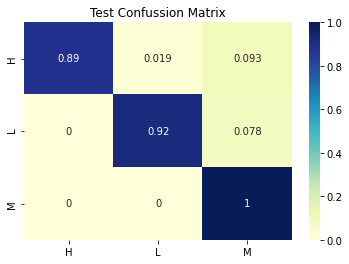

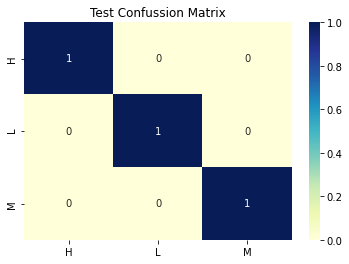

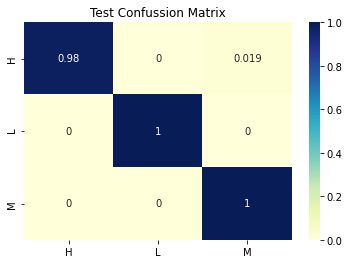

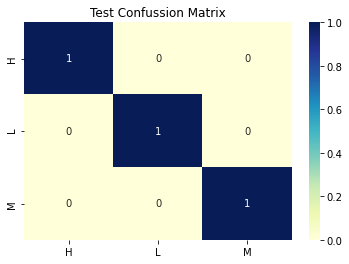

In [6]:
%%time
for k, d in df.items():
    if( k not in exclude ):
        print( 'Dataset ', k, len( d ) )
        grids[ k ] = train_and_test( 
                SVC( probability = True ), params_svc, 
                d[ X_TRAIN ], d[ Y_TRAIN ], 
                d[ X_TEST ], d[ Y_TEST ], 
                plot_cmatrix = True, labels = labels )

# Evaluation

In [7]:
from ml.evaluation import *

## Learning Curves

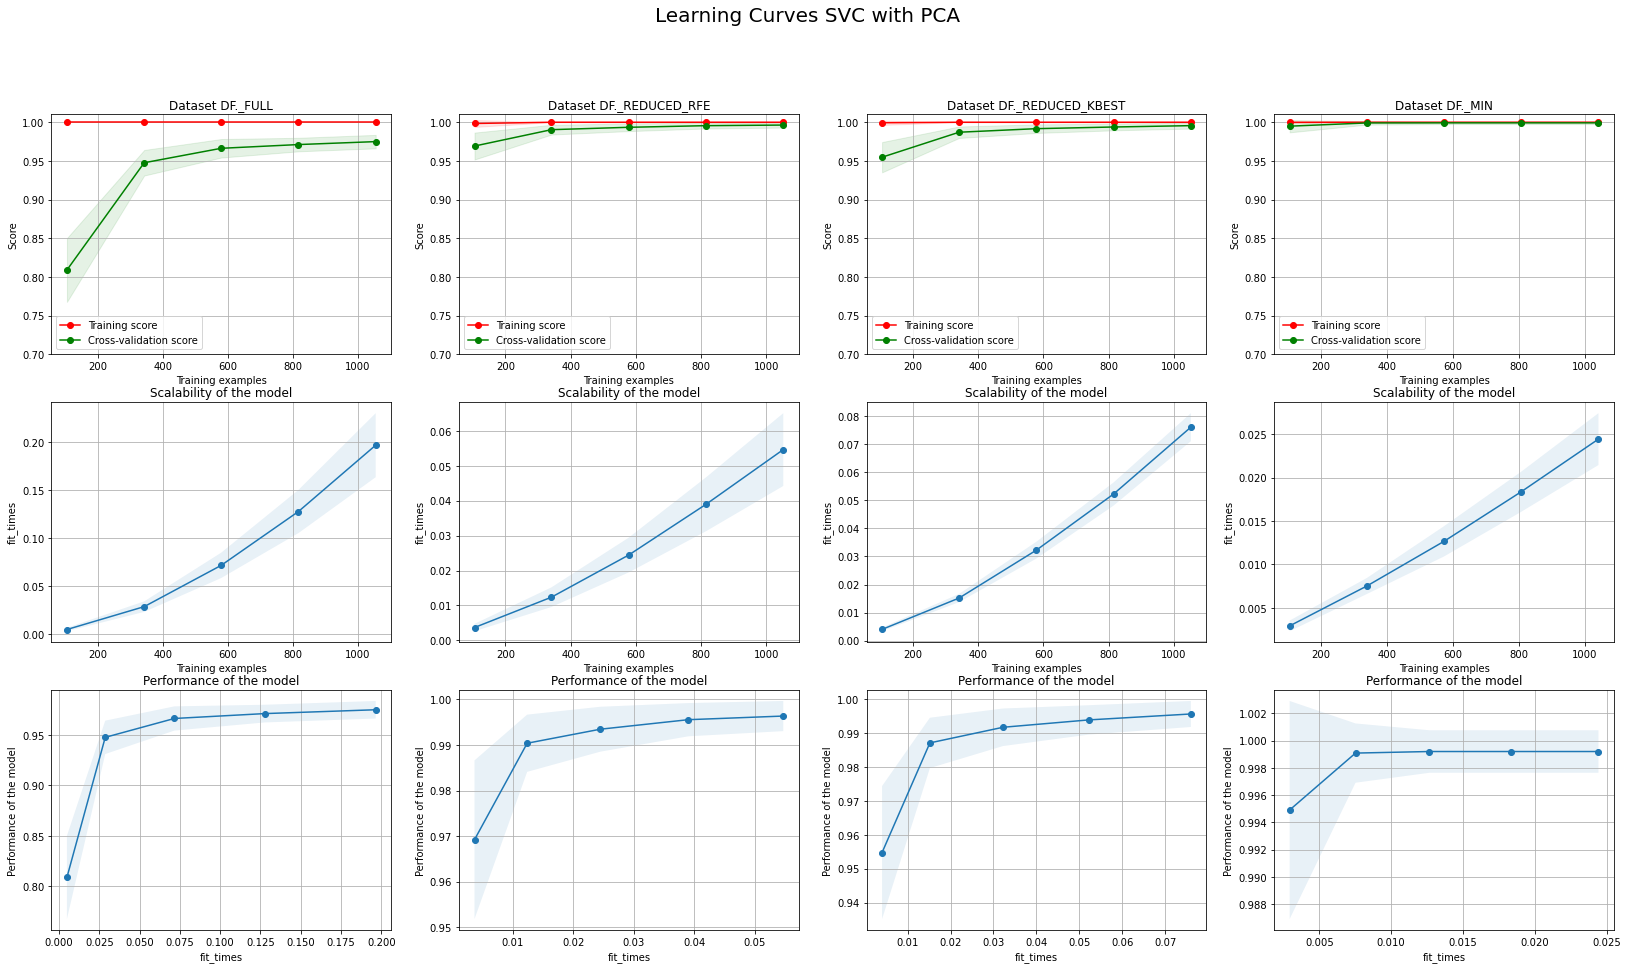

CPU times: user 6.64 s, sys: 443 ms, total: 7.09 s
Wall time: 27.4 s


In [8]:
%%time
temp = [ item for item in df.items() if item[ 0 ] not in exclude ]
plot_learning_curves( temp, grids, 'SVC' )